In [1]:
pip install --upgrade fosforml

Requirement already up-to-date: fosforml in /opt/conda/lib/python3.9/site-packages (1.1.8)
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade numpy

  Using cached https://files.pythonhosted.org/packages/b9/14/78635daab4b07c0930c919d451b8bf8c164774e6a3413aed04a6d95758ce/numpy-2.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
ERROR: snowflake-ml-python 1.5.0 has requirement numpy<2,>=1.23, but you'll have numpy 2.0.2 which is incompatible.
ERROR: scikit-learn 1.3.2 has requirement numpy<2.0,>=1.17.3, but you'll have numpy 2.0.2 which is incompatible.
ERROR: catboost 1.2.7 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 2.0.2 which is incompatible.
  Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade seaborn

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.9/site-packages (0.13.2)
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install pandas
!pip install snowflake-ml-python
!pip install requests

You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/54/30/c2a907b9443cf42b90c17ad10c1e8fa801975f01cb9764f3f8eb8aea638b/numpy-1.26.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
pip install ydata-profiling --upgrade

Requirement already up-to-date: ydata-profiling in /opt/conda/lib/python3.9/site-packages (4.10.0)
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import fosforml
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')

In [8]:
my_session.connection.database

'ASSORTMENT_PLANNING'

In [9]:
my_session.connection.schema

'CPG_BRONZE'

In [10]:
table_name = "ASSORTMENT_PLANNING.CPG_BRONZE.SALES_CLEAN"

In [11]:
sf_df = my_session.sql("select * from {}".format(table_name))

In [12]:
type(sf_df)

snowflake.snowpark.dataframe.DataFrame

In [13]:
df=sf_df.to_pandas()

In [14]:
type(df)

pandas.core.frame.DataFrame

In [15]:
df.head(5)

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND
0,202401,2024-01-18,2024-01-02,1537.89,16,0.001712,1585.454545,202201,DB0706,OL144111,Sedalia,Missouri,City Center,Str4,PRD0064,Hair Care,Conditioner,Bamboo
1,202401,2024-01-28,2024-01-02,518.18,3,0.001125,518.181818,202201,DB0706,OL238706,Williston,North Dakota,City Center,Str1,PRD0113,Perfume and Deodrants,Unisex Deodrant,Navy Blue
2,202401,2024-01-13,2024-01-02,113.64,1,0.000250,113.636364,202201,DB0706,OL223076,Silver City,New Mexico,Santa Cruz,Str1,PRD0107,Lotion,Body Lotion,Coral
3,202401,2024-01-06,2024-01-02,285.71,32,0.000832,285.714286,202201,DB0652,OL175529,Dunkirk,New York,Dolphin,Str3,PRD0147,Kids Care,Baby Cream,Mint
4,202401,2024-01-18,2024-01-02,290.91,1,0.000500,290.909091,202201,DB0652,OL48851,Stroudsburg,Pennsylvania,City Center,Str2,PRD0004,Lotion,Body Lotion,Tan


In [16]:
df.shape

(966400, 18)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966400 entries, 0 to 966399
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   MNTH_CODE         966400 non-null  int32  
 1   TRANS_DATE        966400 non-null  object 
 2   START_DATE        966400 non-null  object 
 3   SALES_VALUE       966400 non-null  float64
 4   SALES_UNITS       966400 non-null  int16  
 5   SALES_VOLUME      966400 non-null  float64
 6   SALES_PTR_VALUE   966400 non-null  float64
 7   OC_CODE           966400 non-null  int32  
 8   DISTRIBUTOR_CODE  966400 non-null  object 
 9   OUTLET_CODE       966400 non-null  object 
 10  CITY              966400 non-null  object 
 11  STATE             966400 non-null  object 
 12  COUNTY            966400 non-null  object 
 13  STREET            966400 non-null  object 
 14  PRODUCT_CODE      966400 non-null  object 
 15  CATEGORY          966400 non-null  object 
 16  SUBCATEGORY       96

In [18]:
df['TRANS_DATE'] = pd.to_datetime(df['TRANS_DATE'])
df['START_DATE'] = pd.to_datetime(df['START_DATE'])

In [19]:
df.describe()

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE
count,966400.000000,966400,966400,966400.000000,966400.000000,966400.000000,966400.000000,966400.000000
mean,202372.876450,2024-03-01 03:47:10.976822272,2024-02-14 23:17:36.278145792,446.417454,12.696476,0.000931,457.814679,202206.573263
min,202309.000000,2023-08-29 00:00:00,2023-08-28 00:00:00,2.860000,1.000000,0.000011,1.785714,202201.000000
25%,202312.000000,2023-11-30 00:00:00,2023-11-27 00:00:00,140.000000,2.000000,0.000368,142.857143,202204.000000
50%,202403.000000,2024-03-03 00:00:00,2024-02-27 00:00:00,192.240000,6.000000,0.000448,198.181818,202207.000000
75%,202406.000000,2024-06-04 00:00:00,2024-05-29 00:00:00,450.000000,16.000000,0.000900,450.000000,202209.000000
max,202408.000000,2024-08-27 00:00:00,2024-07-31 00:00:00,145728.120000,10240.000000,0.275500,151800.000000,202212.000000
std,44.525843,NaN,NaN,1053.355633,40.761336,0.002063,1101.769102,3.404526


In [20]:
df.columns

Index(['MNTH_CODE', 'TRANS_DATE', 'START_DATE', 'SALES_VALUE', 'SALES_UNITS',
       'SALES_VOLUME', 'SALES_PTR_VALUE', 'OC_CODE', 'DISTRIBUTOR_CODE',
       'OUTLET_CODE', 'CITY', 'STATE', 'COUNTY', 'STREET', 'PRODUCT_CODE',
       'CATEGORY', 'SUBCATEGORY', 'BRAND'],
      dtype='object')

In [21]:
df.isnull().sum()

MNTH_CODE           0
TRANS_DATE          0
START_DATE          0
SALES_VALUE         0
SALES_UNITS         0
SALES_VOLUME        0
SALES_PTR_VALUE     0
OC_CODE             0
DISTRIBUTOR_CODE    0
OUTLET_CODE         0
CITY                0
STATE               0
COUNTY              0
STREET              0
PRODUCT_CODE        0
CATEGORY            0
SUBCATEGORY         0
BRAND               0
dtype: int64

In [22]:
df.duplicated().sum()

3158

In [23]:
df.corr(numeric_only=True)

,MNTH_CODE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE
MNTH_CODE,1.000000,-0.007954,-0.011117,-0.005767,-0.007843,-0.791833
SALES_VALUE,-0.007954,1.000000,0.331870,0.925910,0.996460,0.005674
SALES_UNITS,-0.011117,0.331870,1.000000,0.427627,0.334911,0.013232
SALES_VOLUME,-0.005767,0.925910,0.427627,1.000000,0.927547,0.004323
SALES_PTR_VALUE,-0.007843,0.996460,0.334911,0.927547,1.000000,0.006129
OC_CODE,-0.791833,0.005674,0.013232,0.004323,0.006129,1.000000


In [24]:
# Find unique dates
df['TRANS_DATE'].nunique()

303

In [25]:
# Create features from date column
df['YEAR'] = df['TRANS_DATE'].dt.year
df['MONTH'] = df['TRANS_DATE'].dt.month
df['DAY'] = df['TRANS_DATE'].dt.day
df['DAY_OF_WEEK'] = df['TRANS_DATE'].dt.day_of_week + 1 # Monday is 1 and sunday is 7
df['QUARTER'] = df['TRANS_DATE'].dt.quarter
df['DAY_OF_YEAR'] = df['TRANS_DATE'].dt.dayofyear

In [26]:
# Set option to display all columns
pd.set_option('display.max_columns', None)

In [27]:
df.head(5)

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND,YEAR,MONTH,DAY,DAY_OF_WEEK,QUARTER,DAY_OF_YEAR
0,202401,2024-01-18,2024-01-02,1537.89,16,0.001712,1585.454545,202201,DB0706,OL144111,Sedalia,Missouri,City Center,Str4,PRD0064,Hair Care,Conditioner,Bamboo,2024,1,18,4,1,18
1,202401,2024-01-28,2024-01-02,518.18,3,0.001125,518.181818,202201,DB0706,OL238706,Williston,North Dakota,City Center,Str1,PRD0113,Perfume and Deodrants,Unisex Deodrant,Navy Blue,2024,1,28,7,1,28
2,202401,2024-01-13,2024-01-02,113.64,1,0.000250,113.636364,202201,DB0706,OL223076,Silver City,New Mexico,Santa Cruz,Str1,PRD0107,Lotion,Body Lotion,Coral,2024,1,13,6,1,13
3,202401,2024-01-06,2024-01-02,285.71,32,0.000832,285.714286,202201,DB0652,OL175529,Dunkirk,New York,Dolphin,Str3,PRD0147,Kids Care,Baby Cream,Mint,2024,1,6,6,1,6
4,202401,2024-01-18,2024-01-02,290.91,1,0.000500,290.909091,202201,DB0652,OL48851,Stroudsburg,Pennsylvania,City Center,Str2,PRD0004,Lotion,Body Lotion,Tan,2024,1,18,4,1,18


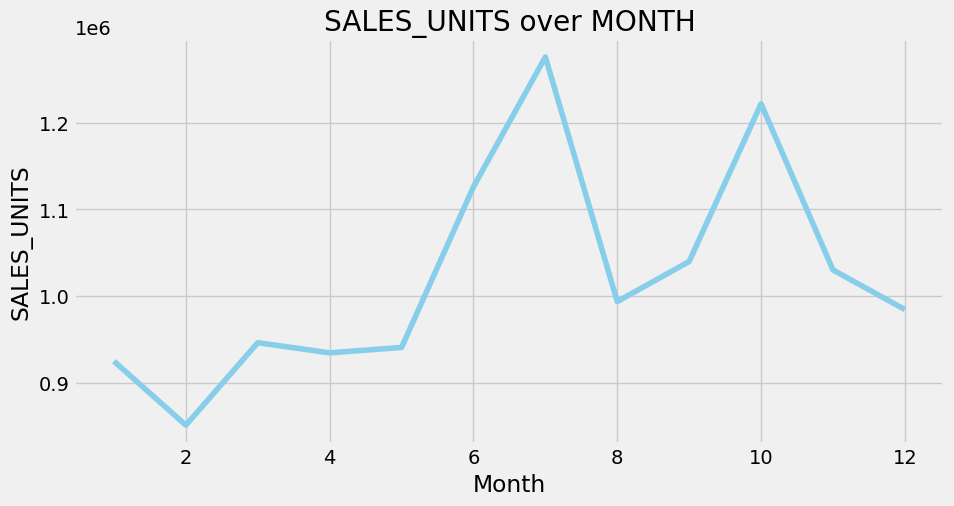

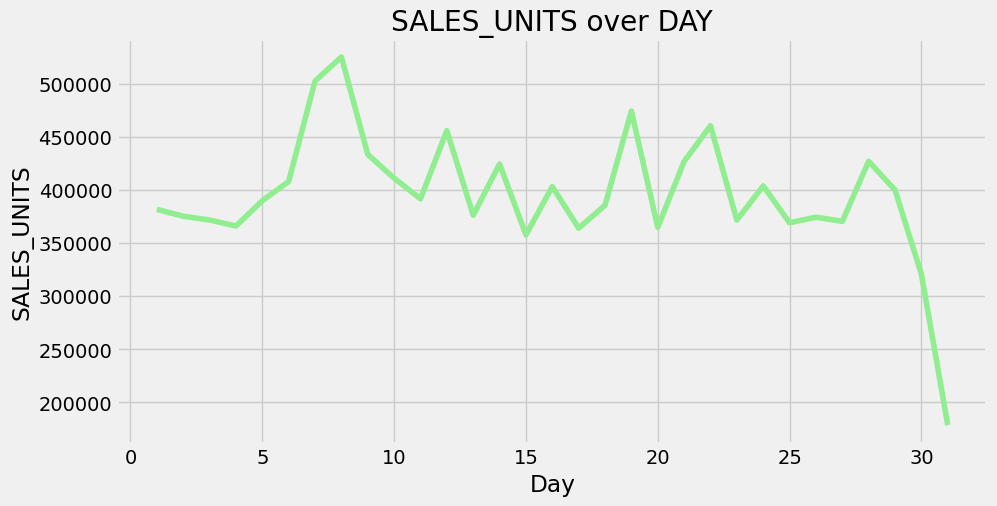

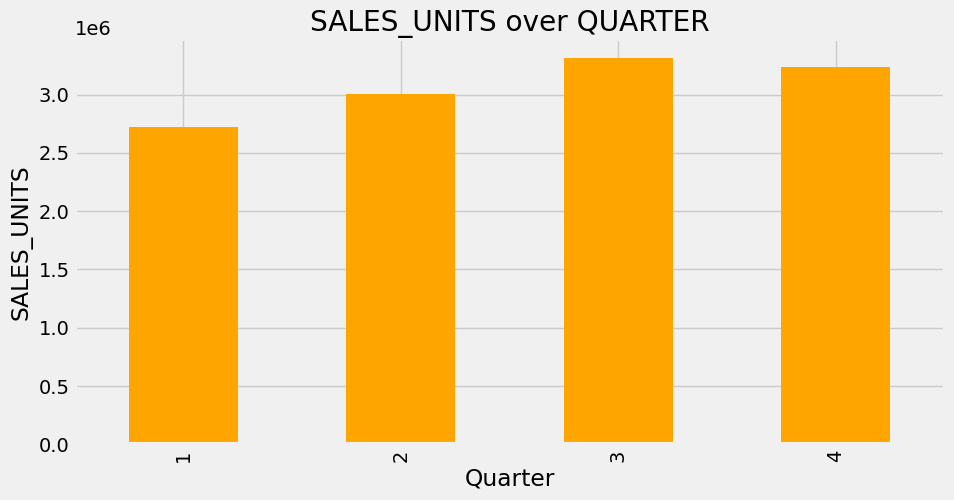

In [36]:
import matplotlib.pyplot as plt
# Plot SALES_UNITS over MONTH
plt.figure(figsize=(10, 5))
df.groupby('MONTH')['SALES_UNITS'].sum().plot(kind='line', color='skyblue')
plt.title('SALES_UNITS over MONTH')
plt.xlabel('Month')
plt.ylabel('SALES_UNITS')
plt.grid(True)
plt.show()

# Plot SALES_UNITS over DAY
plt.figure(figsize=(10, 5))
df.groupby('DAY')['SALES_UNITS'].sum().plot(kind='line', color='lightgreen')
plt.title('SALES_UNITS over DAY')
plt.xlabel('Day')
plt.ylabel('SALES_UNITS')
plt.grid(True)
plt.show()


# Plot SALES_UNITS over QUARTER
plt.figure(figsize=(10, 5))
df.groupby('QUARTER')['SALES_UNITS'].sum().plot(kind='bar', color='orange')
plt.title('SALES_UNITS over QUARTER')
plt.xlabel('Quarter')
plt.ylabel('SALES_UNITS')
plt.grid(True)
plt.show()

In [ ]:
'''from ydata_profiling import ProfileReport
profile=ProfileReport(df,explorative=True)
profile.to_file("autoeda_v1.html")

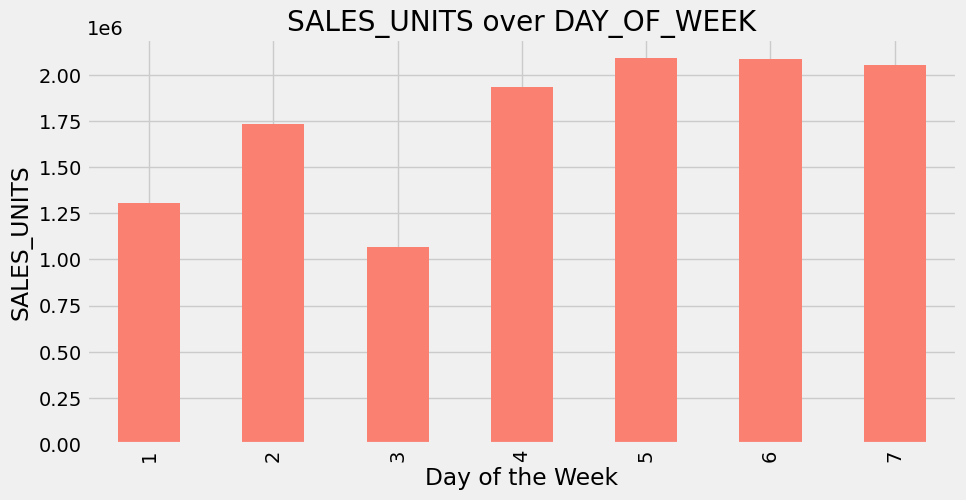

In [35]:
# Plot SALES_UNITS over DAY_OF_WEEK
plt.figure(figsize=(10, 5))
df.groupby('DAY_OF_WEEK')['SALES_UNITS'].sum().plot(kind='bar', color='salmon')
plt.title('SALES_UNITS over DAY_OF_WEEK')
plt.xlabel('Day of the Week')
plt.ylabel('SALES_UNITS')
plt.grid(True)
plt.show()